<a href="https://colab.research.google.com/github/Hikaros/ML-Forex-Time-Series-Predictions/blob/master/Price_and_RSI_Model_(good).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()
!ls
# !rm  XAUUSD1440.csv

Saving Convert_Series_To_Supervised_Learning.py to Convert_Series_To_Supervised_Learning.py
Saving EURUSD.csv to EURUSD.csv
Saving GBP_USD Historical Data.csv to GBP_USD Historical Data.csv
Saving Hikaros_forex_functions.py to Hikaros_forex_functions.py
Saving technical_indicators.py to technical_indicators.py
Saving US Dollar Index Historical Data.csv to US Dollar Index Historical Data.csv
Saving USD_CHF Historical Data.csv to USD_CHF Historical Data.csv
 Convert_Series_To_Supervised_Learning.py
 EURUSD.csv
'GBP_USD Historical Data.csv'
 Hikaros_forex_functions.py
 sample_data
 technical_indicators.py
'USD_CHF Historical Data.csv'
'US Dollar Index Historical Data.csv'


In [0]:
import math
import os
import numpy as np
import pandas as pd
from Hikaros_forex_functions import dukascopy_data_man
from Convert_Series_To_Supervised_Learning import series_to_supervised
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from scipy.signal import argrelextrema
from keras.layers import Embedding
from pandas import DataFrame
from pandas import read_csv
from datetime import datetime
from technical_indicators import relative_strength_index

Using TensorFlow backend.


In [0]:
# GOLD = "XAUUSD_Candlestick_1_D_ASK_05.05.2003-07.01.2020.csv"
# GOLD = dukascopy_data_man(GOLD)

In [0]:
# Dataset
dataset = read_csv("EURUSD.csv")
# Set RSI
dataset["RSI"]=relative_strength_index(dataset,14)["RSI_14"]
# index Date
dataset["Date"]=pd.to_datetime(dataset["Date"],format="%Y.%m.%d")
dataset = dataset.set_index(dataset["Date"])
dataset.drop(["Date","Open","High","Low"],axis=1,inplace=True)
# dataset.drop(["Date"],axis=1,inplace=True)
# Add GOLD
# dataset["GOLD"] = GOLD["Close"]
# dataset["USDX"] = USDX["Close"]
# Fill zeros
dataset['RSI'].fillna(method="bfill", inplace=True)
# dataset['GOLD'].fillna(method='ffill', inplace=True)
# dataset['GOLD'].fillna(0, inplace=True)
# dataset['USDX'].fillna(method='ffill', inplace=True)
# dataset['USDX'].fillna(0, inplace=True)
dataset

,Close,RSI
Date,,
1990-01-01,1.14260,0.335846
1990-01-02,1.13090,0.335846
1990-01-03,1.16720,0.335846
1990-01-04,1.15920,0.335846
1990-01-07,1.17240,0.335846
...,...,...
2019-12-31,1.12154,0.867247
2020-01-02,1.11712,0.700157
2020-01-03,1.11564,0.563211


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


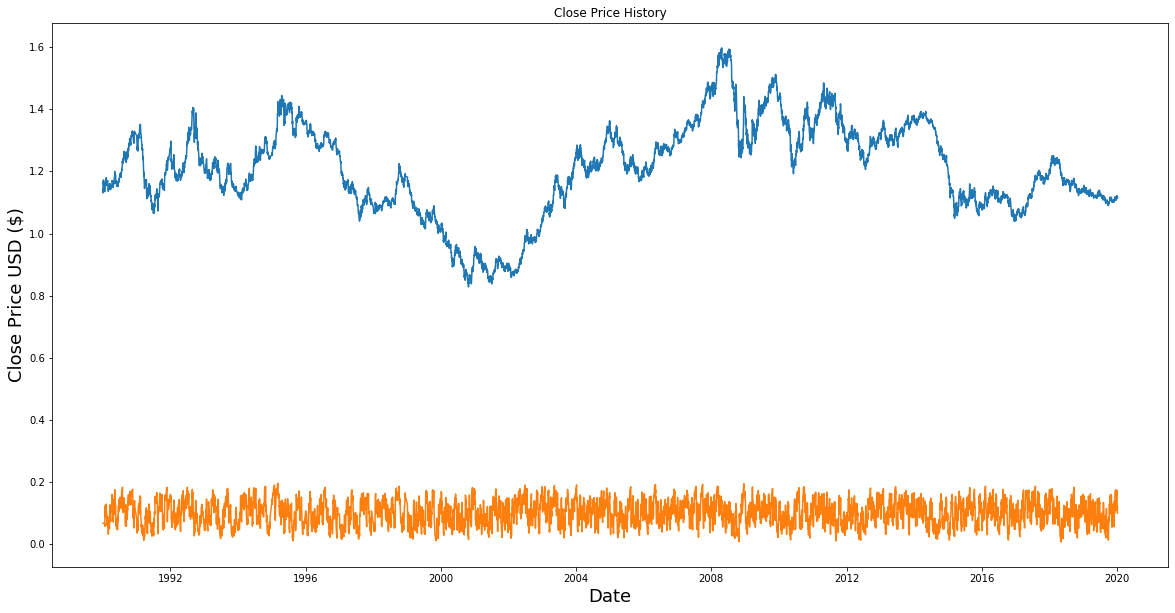

In [0]:
#Visualize the closing price history
plt.figure(figsize=(20,10))
plt.title('Close Price History')
plt.plot(dataset["Close"])
# plt.plot(dataset["USDX"]*0.0001)
# plt.plot(dataset["GOLD"]*0.001)
plt.plot(dataset["RSI"]*0.2)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [0]:

#Convert the dataframe to a numpy array
values = dataset.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)

# drop columns we don't want to predict
reframed.drop(reframed.columns[-1:], axis=1, inplace=True)
print(reframed)
reframed.shape


      var1(t-1)  var2(t-1)   var1(t)   var2(t)
1      0.408890   0.319149  0.393683  0.319149
2      0.393683   0.319149  0.440863  0.319149
3      0.440863   0.319149  0.430465  0.319149
4      0.430465   0.319149  0.447621  0.319149
5      0.447621   0.319149  0.440863  0.319149
...         ...        ...       ...       ...
8772   0.379465   0.862825  0.381518  0.880017
8773   0.381518   0.880017  0.375773  0.703661
8774   0.375773   0.703661  0.373850  0.559122
8775   0.373850   0.559122  0.378906  0.619480
8776   0.378906   0.619480  0.372095  0.490822

[8776 rows x 4 columns]
      var1(t-1)  var2(t-1)   var1(t)
1      0.408890   0.319149  0.393683
2      0.393683   0.319149  0.440863
3      0.440863   0.319149  0.430465
4      0.430465   0.319149  0.447621
5      0.447621   0.319149  0.440863
...         ...        ...       ...
8772   0.379465   0.862825  0.381518
8773   0.381518   0.880017  0.375773
8774   0.375773   0.703661  0.373850
8775   0.373850   0.559122  0.378906
8776

(8776, 3)

In [0]:
# split into train and test sets
values = reframed.values
n_train_hours = int(values.shape[0]/8776*7000)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7000, 1, 2) (7000,) (1776, 1, 2) (1776,)


In [0]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(100, return_sequences= False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 100)            41200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 50)             30200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 131,901
Trainable params: 131,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 7000 samples, validate on 1776 samples
Epoch 1/20
 - 4s - loss: 0.1037 - val_loss: 0.0875
Epoch 2/20
 - 1s - loss: 0.0418 - val_loss: 0.0787
Epoch 3/20
 - 1s - loss: 0.0435 - val_loss: 0.0644
Epoch 4/20
 - 1s - loss: 0.0394 - val_loss: 0.0575
Epoch 5/20
 - 1s - loss: 0.0338 - val_loss: 0.0523
Epoch 6/20
 - 1s - loss: 0.0276 - val_loss: 0.0449
Epoch 7/20
 - 1s - loss: 0.0209 - val_loss: 0.0341
Epoch 8/20
 - 1s - loss: 0.0143 - val_loss: 0.0211
Epoch 9/20
 - 1s - loss: 0.0086 - val_loss: 0.0099
Epoch 10/20
 - 1s - loss: 0.0045 - val_loss: 0.0033
Epoch 11/20
 - 1s - loss: 0.0021 - val_loss: 7.3284e-04
Epoch 12/20
 - 1s - loss: 9.4868e-04 - val_loss: 1.2635e-04
Epoch 13/20
 - 1s - loss: 4.8184e-04 - val_loss: 8.2769e-05
Epoch 14/20
 - 1s - loss: 3.3740e-04 - val_loss: 8.4873e-05
Epoch 15/20
 - 1s - loss: 2.9413e-04 - val_loss: 7.6712e-05
Epoch 16/20
 - 1s - loss: 2.7428e-04 - val_loss: 6.8258e-05
Epoch 17/20
 - 1s - loss: 2.5985e-04 - val_loss: 6.1590e-05
Epoch 18/20
 - 1s - loss:

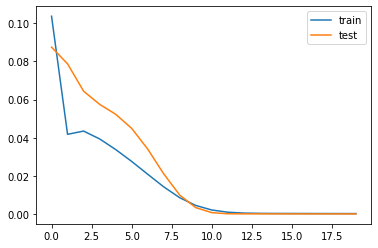

In [0]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
test_X, y_test = test[:, :-1], test[:, -1]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print(inv_yhat)
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print(inv_y)
print(inv_y.shape)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


[1.3797395 1.3812418 1.3833107 ... 1.1152548 1.1146637 1.1181446]
[1.38068 1.38167 1.38302 ... 1.11564 1.11953 1.11429]
(1776,)
Test RMSE: 0.005


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


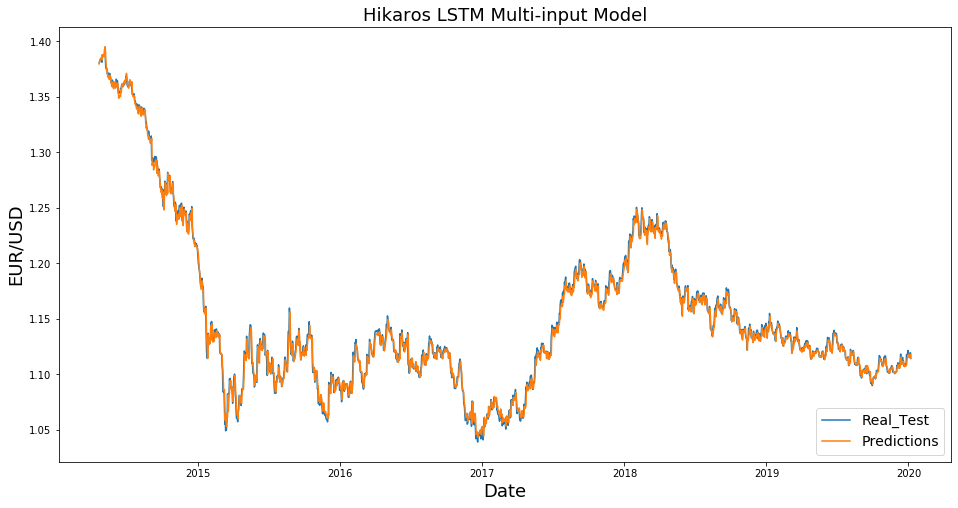

In [0]:
#Plot the data
data = dataset.filter(["Close"])
train = data[1:n_train_hours]
valid = data[n_train_hours+1:]
valid['Predictions'] = inv_yhat
# print(valid)
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Hikaros LSTM Multi-input Model',fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('EUR/USD', fontsize=18)
# plt.plot(train[symbol])
# plt.plot(train)
plt.plot(valid[["Close","Predictions"]])
plt.legend(["Real_Test", 'Predictions'], loc='lower right' , fontsize=14)
plt.show()

(1776, 1)
(1776,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


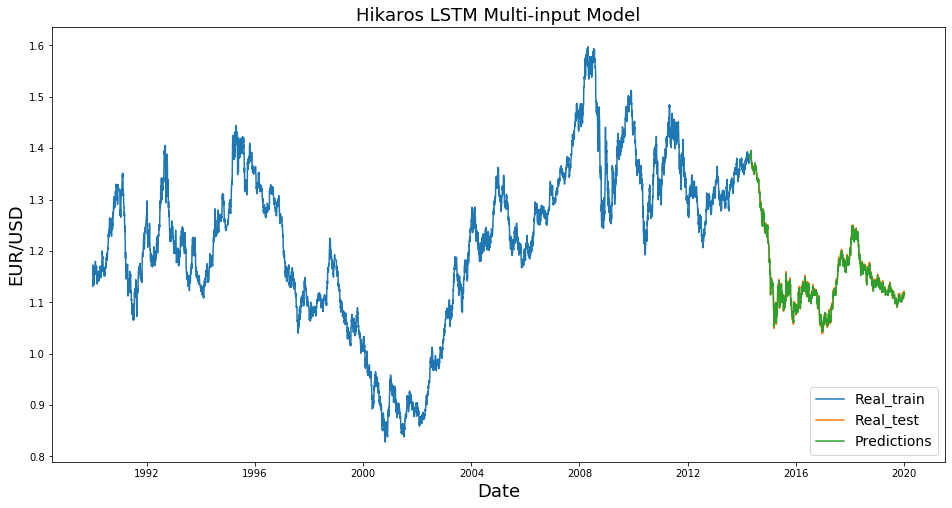

In [0]:
#Plot the data
data = dataset.filter(["Close"])
train = data[:n_train_hours]
valid = data[n_train_hours+1:]
print(valid.shape)
print(inv_yhat.shape)
valid['Predictions'] = inv_yhat
# print(valid)
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Hikaros LSTM Multi-input Model',fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('EUR/USD', fontsize=18)
# plt.plot(train[symbol])
plt.plot(train)
plt.plot(valid[["Close","Predictions"]])
plt.legend(["Real_train",'Real_test', 'Predictions'], loc='lower right', fontsize=14)
plt.show()

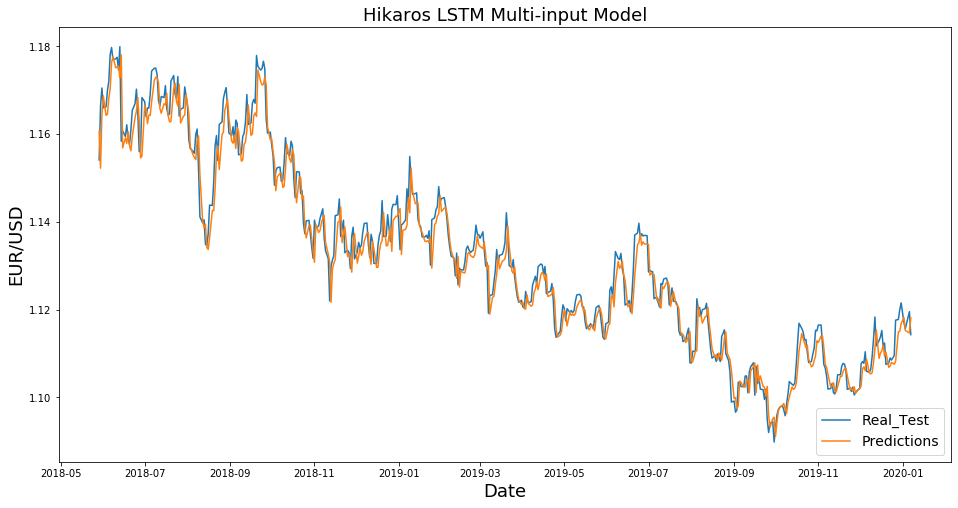

In [0]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Hikaros LSTM Multi-input Model',fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('EUR/USD', fontsize=18)
# plt.plot(train[symbol])
# plt.plot(train)
plt.plot(valid[["Close","Predictions"]][-500:])
plt.legend(["Real_Test", 'Predictions'], loc='lower right',fontsize=14)
plt.show()